In [202]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(1)

In [203]:
input_size = 2
hidden_size = 64
num_layers = 1
output_size = 1
lr = 0.0001
epochs = 100
batch_size = 1
# 拿幾天前來預測
days_before = 3
# 有多少機台
num_machine = 5
# 我們有的資料天數
days_of_sample = 14
# 訓練、測試比例
split_rate = 0.8

In [204]:
df=pd.read_csv("data.csv",encoding='big5')
df=df[df.index%2==1]
df06=df[df['機台號']=="h06"]
df14=df[df['機台號']=="h14"]

df01=df[df['機台號']=="h01"]
df02=df[df['機台號']=="h02"]
df08=df[df['機台號']=="h08"]
df10=df[df['機台號']=="h10"]
df15=df[df['機台號']=="h15"]
df19=df[df['機台號']=="h19"]

In [205]:
df06.reset_index(drop=True, inplace=True)
df14.reset_index(drop=True, inplace=True)
df01.reset_index(drop=True, inplace=True)
df01 = df01[df01.index%2==0]
df01.reset_index(drop=True, inplace=True)
df02.reset_index(drop=True, inplace=True)
df02 = df02[df02.index%2==0]
df02.reset_index(drop=True, inplace=True)
df08.reset_index(drop=True, inplace=True)
df08 = df08[df08.index%2==0]
df08.reset_index(drop=True, inplace=True)
df10.reset_index(drop=True, inplace=True)
df10 = df10[df10.index%2==0]
df10.reset_index(drop=True, inplace=True)
df15.reset_index(drop=True, inplace=True)
df15 = df15[df15.index%2==0]
df15.reset_index(drop=True, inplace=True)
df19.reset_index(drop=True, inplace=True)
df19 = df19[df19.index%2==0]
df19.reset_index(drop=True, inplace=True)

In [206]:
df1G = pd.concat([df06, df14], axis=0)
df1G.sort_values(by=['生產日期','機台號'], inplace = True)
df1G.reset_index(drop=True, inplace=True)
# df15沒加進去
df10G = pd.concat([df01, df02, df08, df10, df19], axis=0)
df10G.sort_values(by=['生產日期','機台號'], inplace = True)
df10G.reset_index(drop=True, inplace=True)
df = pd.concat([df1G, df10G], axis = 0)
df.sort_values(by=['生產日期','機台號'], inplace = True)
df.reset_index(drop=True, inplace=True)

X10G = df10G.drop(["生產日期", "機台號", "班別","產能"], axis=1)

In [207]:
X10G

,OEE,良率
0,72.9,94.3
1,81.2,94.8
2,74.7,91.1
3,62.7,91.2
4,75.5,92.2
...,...,...
65,72.4,90.1
66,71.1,94.8
67,54.9,86.7
68,68.3,96.9


In [208]:
# 計算每日總產能
Y10G = pd.DataFrame(columns=['產能'])
row, col = df10G.shape
for i in range(days_of_sample):
    Y10G.loc[i,'產能']=sum([df10G.loc[n+i*num_machine,'產能'] for n in range(num_machine)])
Y10G

,產能
0,9948
1,9900
2,9683
3,8997
4,10124
5,10527
6,9735
7,8604
8,10058
9,9704


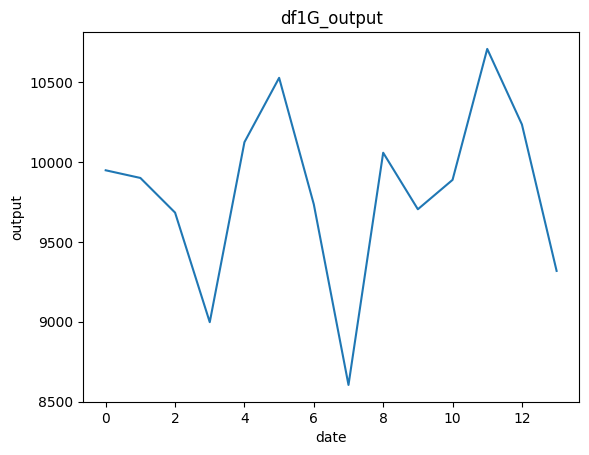

In [209]:
date = Y10G.index
plt.plot(date, Y10G)
plt.title("df1G_output")
plt.xlabel("date")
plt.ylabel("output")
plt.show()

# 正規化
mean_10G = Y10G["產能"].mean()
std_10G = Y10G["產能"].std()
X10G = X10G.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
Y10G = Y10G.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [210]:
def create_sequence(data, output, seq_len):
    xs = []
    ys = []
    row, col = data.shape
    # 每次移5個機台
    for i in range(int((row - seq_len)/num_machine)):
        x = data[i*num_machine:i*num_machine+seq_len]
        y = []
        # y為三天後的產能
        y.append(output[i+seq_len//num_machine][0])
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)
        

In [211]:
X10G_array = np.array(X10G)
Y10G_array = np.array(Y10G)
# 3天份資料
seq_len = days_before*num_machine
X, Y = create_sequence(X10G_array,Y10G_array, seq_len)
train_size = int(len(X) * split_rate)
Y

array([[-1.46178674],
       [ 0.54885498],
       [ 1.26783334],
       [-0.14514646],
       [-2.16292445],
       [ 0.43110666],
       [-0.20045249],
       [ 0.12781554],
       [ 1.59074918],
       [ 0.74688624],
       [-0.88910174]])

In [212]:
train_X = torch.tensor(np.array(X[:train_size]), dtype=torch.float)
train_Y = torch.tensor(np.array(Y[:train_size]), dtype=torch.float)
test_X = torch.tensor(np.array(X[train_size:]), dtype=torch.float)
test_Y = torch.tensor(np.array(Y[train_size:]), dtype=torch.float)

In [213]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_size)
        c0 = torch.zeros(1, input_seq.size(0), self.hidden_size)
        output, (hn, cn) = self.lstm(input_seq, (h0, c0))
        output = self.fc(output[:, -1, :])
        return output


In [214]:
model_01 = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
print(model_01)

LSTM(
  (lstm): LSTM(2, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Epoch 0, Loss: 0.01595326140522957
Epoch 1, Loss: 0.016726594418287277
Epoch 2, Loss: 0.017510002478957176
Epoch 3, Loss: 0.01830773428082466
Epoch 4, Loss: 0.019120680168271065
Epoch 5, Loss: 0.019949045032262802
Epoch 6, Loss: 0.020792892202734947
Epoch 7, Loss: 0.021652260795235634
Epoch 8, Loss: 0.022527238354086876
Epoch 9, Loss: 0.023417945951223373
Epoch 10, Loss: 0.02432454749941826
Epoch 11, Loss: 0.025247247889637947
Epoch 12, Loss: 0.026186279952526093
Epoch 13, Loss: 0.027141911908984184
Epoch 14, Loss: 0.028114456683397293
Epoch 15, Loss: 0.029104236513376236
Epoch 16, Loss: 0.030111610889434814
Epoch 17, Loss: 0.031137000769376755
Epoch 18, Loss: 0.032180819660425186
Epoch 19, Loss: 0.033243536949157715
Epoch 20, Loss: 0.034325674176216125
Epoch 21, Loss: 0.035427775233983994
Epoch 22, Loss: 0.036550428718328476
Epoch 23, Loss: 0.037694286555051804
Epoch 24, Loss: 0.038860052824020386
Epoch 25, Loss: 0.04004848003387451
Epoch 26, Loss: 0.041260384023189545
Epoch 27, Loss:

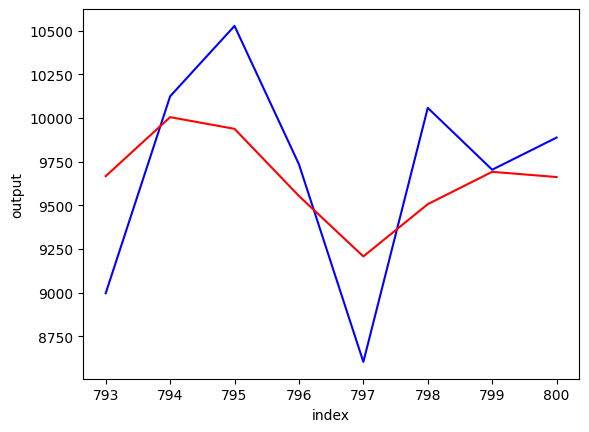

In [215]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_01.parameters(), lr=lr)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_X, train_Y), batch_size=batch_size, shuffle=False)

train_pre = []
train = []

for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        outputs = model_01(inputs)
        loss = criterion(outputs, targets)
        outputs = outputs.detach().numpy()
        outputs = outputs.ravel()
        train_pre.append(outputs)

        targets = targets.detach().numpy()
        targets = targets.ravel()
        train.append(targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch {}, Loss: {}".format(epoch, loss.item()))

size = train_size*epochs
# 預測
train_pre = np.array(train_pre)
# 實際
train = np.array(train)
train_pre = train_pre.reshape(size)
train = train.reshape(size)

for i in range(size):
    train_pre[i] = train_pre[i]*std_10G+mean_10G
    train[i] = train[i]*std_10G+mean_10G
index = [i+1 for i in range(size)]
# 計算誤差
num =0
for i in range(size):
    num += train_pre[i] - train[i]
print(num)

# 看最後一個epoch
plt.xlabel("index")
plt.ylabel("output")
plt.plot(index[size-train_size:size], train[size-train_size:size], 'b', label="real")
plt.plot(index[size-train_size:size], train_pre[size-train_size:size], 'r', label="predict")
plt.show()


Test Loss: 3.2660
[9377.914 9141.683 8980.559]
[10708. 10235.  9318.]
-2760.8447265625


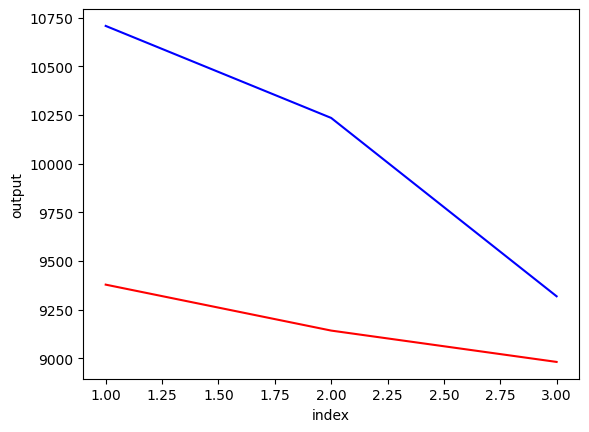

In [216]:
model_01.eval()
with torch.no_grad():
    test_outputs = model_01(test_X)
    test_loss = criterion(test_outputs, test_Y)
    print('Test Loss: {:.4f}'.format(test_loss.item()))

test_outputs = test_outputs.numpy()
test_outputs = test_outputs.ravel()

for i in range(len(test_outputs)):
    test_outputs[i] = test_outputs[i]*std_10G+mean_10G

test_Y = test_Y.numpy()
test_Y = test_Y.ravel()

for i in range(len(test_Y)):
    test_Y[i] = test_Y[i]*std_10G+mean_10G
    
print(test_outputs)
print(test_Y)

num =0
for i in range(len(test_Y)):
    num += test_outputs[i] - test_Y[i]

print(num)
index = [i+1 for i in range(days_before)]

# 畫出預測的圖
plt.xlabel("index")
plt.ylabel("output")
plt.plot(index, test_Y, 'b', label="real")
plt.plot(index, test_outputs, 'r', label="predict")
plt.show()